In [281]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid

In [282]:
# define evaluation metrics for volatility forecasting
def rmse_var(y_true, y_pred, is_vol=False):
    if is_vol:
        y_true = np.square(y_true)
        y_pred = np.square(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


def qlike_var(y_true, y_pred, is_vol=False, eps=1e-12):
    if is_vol:
        y_true = np.square(y_true)
        y_pred = np.square(y_pred)
    ratio = (y_true + eps) / (y_pred + eps)
    return float(np.mean(ratio - np.log(ratio) - 1.0))


### Building XGBoost

In [283]:
btc_df = pd.read_csv('../Data/btc_final_df.csv')

In [284]:
def purged_rolling_cv(df, n_splits=5, purge_hours=24):
    df = df.sort_values("timestamp").reset_index(drop=True)
    n = len(df)
    fold_size = n // n_splits
    splits = []

    for i in range(n_splits):
        train_end = (i + 1) * fold_size
        test_start = train_end
        test_end = min(test_start + fold_size, n)

        # Purge gap between train and test
        purge_start_time = df.loc[train_end - 1, "timestamp"] + pd.Timedelta(hours=purge_hours)
        valid_test_idx = [j for j in range(test_start, test_end)
                          if df.loc[j, "timestamp"] > purge_start_time]

        if len(valid_test_idx) > 0:
            train_idx = np.arange(0, train_end)
            splits.append((train_idx, np.array(valid_test_idx)))

    return splits

In [285]:
def split_train_test(df, train_ratio=0.85):
    df = df.sort_values("timestamp").reset_index(drop=True)
    n = len(df)
    train_end = int(n * train_ratio)

    train_df = df.iloc[:train_end].copy()
    test_df = df.iloc[train_end:].copy()
    print(f"Train/Val samples: {len(train_df)}, Test samples: {len(test_df)}")
    return train_df, test_df

In [286]:
def tune_model_cv(train_df, features, target='vol_future',
                  param_grid=None, n_splits=5, purge_hours=24):

    print(f"\nTuning hyperparameters on 85% training/validation (5-fold rolling CV, {purge_hours}h purge)...")

    if param_grid is None:
        param_grid = {
            'max_depth': [2, 3, 5],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [200, 400],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }

    X, y = train_df[features].values, train_df[target].values
    splits = purged_rolling_cv(train_df, n_splits=n_splits, purge_hours=purge_hours)

    best_score = np.inf
    best_params = None
    results = []

    for params in ParameterGrid(param_grid):
        fold_scores = []
        for train_idx, test_idx in splits:
            model = XGBRegressor(random_state=42, n_jobs=-1, **params)
            model.fit(X[train_idx], y[train_idx], verbose=False)
            y_pred = model.predict(X[test_idx])
            score = np.sqrt(np.mean((y[test_idx] - y_pred)**2))  # RMSE
            fold_scores.append(score)
        mean_score = np.mean(fold_scores)
        results.append({'params': params, 'mean_rmse': mean_score})
        if mean_score < best_score:
            best_score = mean_score
            best_params = params

    results_df = pd.DataFrame(results).sort_values('mean_rmse').reset_index(drop=True)
    print("Best tuned parameters:", best_params)
    print(f"Best CV RMSE: {best_score:.6f}")
    return best_params, results_df

In [287]:
def train_and_test(df, features, target='vol_future', param_grid=None):
    train_df, test_df = split_train_test(df)

    # Step 1: Tune hyperparameters on 85% using purged rolling CV
    best_params, results_df = tune_model_cv(train_df, features, target, param_grid)

    # Step 2: Retrain final model on entire 85% set with best params
    print("\nRetraining final model on full 85% data with tuned parameters...")
    X_train, y_train = train_df[features], train_df[target]
    final_model = XGBRegressor(**best_params, random_state=42, n_jobs=-1)
    final_model.fit(X_train, y_train, verbose=False)

    # Step 3: Evaluate on 15% test hold-out
    print("\nEvaluating on 15% test set...")
    X_test, y_test = test_df[features], test_df[target]
    y_pred = final_model.predict(X_test)

    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    ql = qlike_var(y_test, y_pred, is_vol=True)

    print(f"Test Results — QLIKE: {ql:.6f}, RMSE: {rmse:.6f}")

    predictions_df = test_df[['timestamp', target]].copy()
    predictions_df['pred_vol_future'] = y_pred

    return final_model, best_params, results_df, predictions_df

In [288]:
# Ensure timestamp is datetime
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])

# Feature columns
features = [c for c in btc_df.columns if c not in ['timestamp', 'vol_future']]

# Train, tune, and test
model, best_params, cv_results, predictions_df = train_and_test(btc_df, features)

Train/Val samples: 6976, Test samples: 1232

Tuning hyperparameters on 85% training/validation (5-fold rolling CV, 24h purge)...
Best tuned parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.8}
Best CV RMSE: 0.338293

Retraining final model on full 85% data with tuned parameters...

Evaluating on 15% test set...
Test Results — QLIKE: 0.013428, RMSE: 0.469587


### Plotting of results and Feature importance

In [289]:
## importing libraries
import matplotlib.pyplot as plt


In [290]:

def plot_predicted_vs_actual(predictions_df, title="Predicted vs Actual Volatility (Test Set)"):
    """
    Plot predicted vs actual volatility for the test set.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(predictions_df['timestamp'], predictions_df['vol_future'], label='Actual Volatility', linewidth=2)
    plt.plot(predictions_df['timestamp'], predictions_df['pred_vol_future'], label='Predicted Volatility', linewidth=2, linestyle='--')
    
    plt.title(title, fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Volatility", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


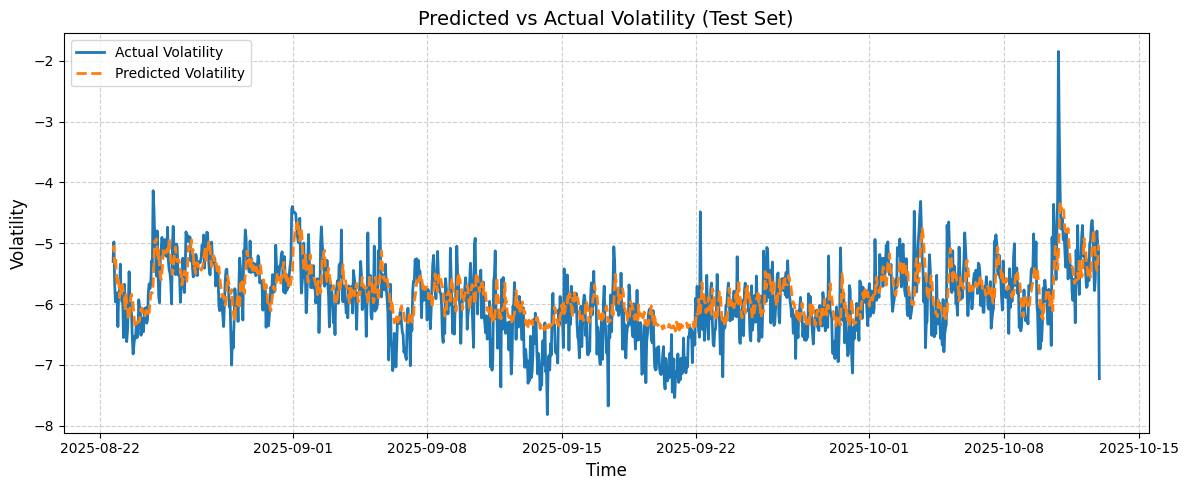

In [291]:
# Plot results
plot_predicted_vs_actual(predictions_df)


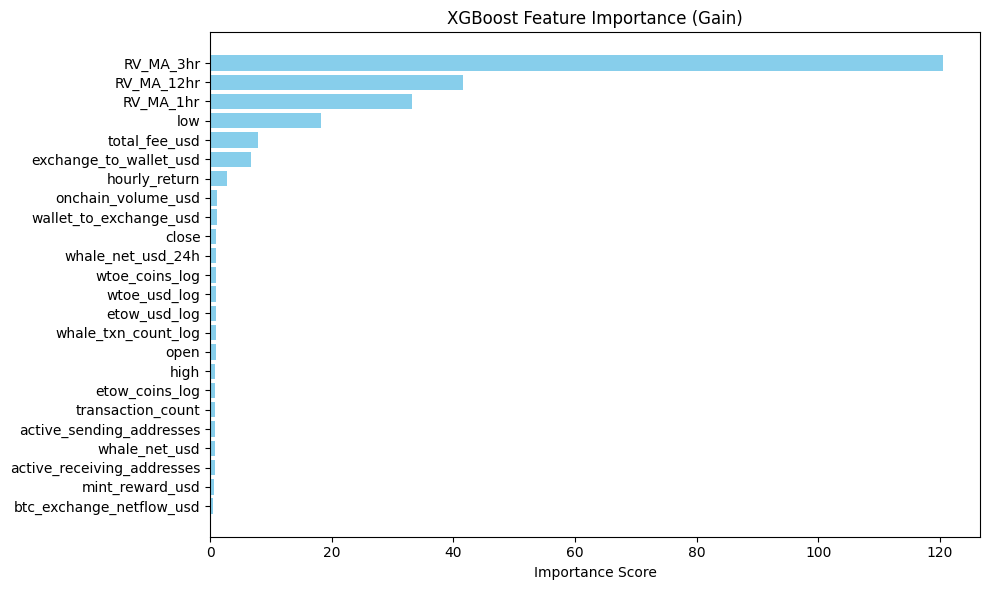

In [292]:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = (
    pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
    .sort_values('Importance', ascending=True)
)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title("XGBoost Feature Importance (Gain)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [293]:
predictions_df.to_csv('../Results/btc_xgb_prediction.csv', index=False)